In [2]:
import pandas as pd

files = {
    "ephem_clean": "/Users/kamayanirai/Downloads/DATASETS/ephemeris_points_clean.csv",
    "state_vec": "/Users/kamayanirai/Downloads/DATASETS/state_vectors_eci.csv",
    "udl_vec": "/Users/kamayanirai/Downloads/DATASETS/udl_statevectors.csv",
    "objects": "/Users/kamayanirai/Downloads/DATASETS/object_of_interest.csv"
}


for name, path in files.items():
    df = pd.read_csv(path, nrows=5)   # just first 5 rows
    print(f"\n{name} columns -> {df.columns.tolist()}")



ephem_clean columns -> ['classificationMarking', 'esId', 'pointId', 'x_km', 'y_km', 'z_km', 'vx_kms', 'vy_kms', 'vz_kms', 'source_x', 'pointStartTime', 'pointEndTime', 'referenceFrame', 'source_y', 'epoch']

state_vec columns -> ['epoch', 'object_id', 'reference_frame', 'x_ecef_km', 'y_ecef_km', 'z_ecef_km', 'vx_ecef_km_s', 'vy_ecef_km_s', 'vz_ecef_km_s', 'source_system', 'x_eci_km', 'y_eci_km', 'z_eci_km', 'vx_eci_km_s', 'vy_eci_km_s', 'vz_eci_km_s', 'frame_standard']

udl_vec columns -> ['epoch', 'source', 'origObjectId', 'xpos', 'ypos', 'zpos', 'xvel', 'yvel', 'zvel', 'classificationMarking', 'referenceFrame']

objects columns -> ['createdAt', 'id', 'name', 'origin', 'classificationMarking', 'updatedAt', 'description', 'source', 'status', 'idOnOrbit', 'elsetEpoch', 'svEpoch']


In [ ]:
import pandas as pd

# Load CSVs
ephem_clean = pd.read_csv("/Users/kamayanirai/Downloads/DATASETS/ephemeris_points_clean.csv")
state_vec = pd.read_csv("/Users/kamayanirai/Downloads/DATASETS/state_vectors_eci.csv")
udl_vec = pd.read_csv("/Users/kamayanirai/Downloads/DATASETS/udl_statevectors.csv")
objects = pd.read_csv("/Users/kamayanirai/Downloads/DATASETS/object_of_interest.csv")

# --- Rename columns ---
ephem_clean.rename(columns={
    "esId": "object_id",
    "epoch": "epoch",
    "x_km": "x", "y_km": "y", "z_km": "z",
    "vx_kms": "vx", "vy_kms": "vy", "vz_kms": "vz"
}, inplace=True)

state_vec.rename(columns={
    "x_eci_km": "x", "y_eci_km": "y", "z_eci_km": "z",
    "vx_eci_km_s": "vx", "vy_eci_km_s": "vy", "vz_eci_km_s": "vz"
}, inplace=True)

udl_vec.rename(columns={
    "origObjectId": "object_id",
    "xpos": "x", "ypos": "y", "zpos": "z",
    "xvel": "vx", "yvel": "vy", "zvel": "vz"
}, inplace=True)

objects.rename(columns={"id": "object_id"}, inplace=True)

# --- Ensure consistent dtypes ---
for df in [ephem_clean, state_vec, udl_vec, objects]:
    if "object_id" in df.columns:
        df["object_id"] = df["object_id"].astype(str).str.strip()

# --- Convert epoch to datetime ---
for df in [ephem_clean, state_vec, udl_vec]:
    if "epoch" in df.columns:
        df["epoch"] = pd.to_datetime(df["epoch"], errors="coerce")

# --- Merge step by step ---
merged = ephem_clean.merge(
    state_vec[["object_id","epoch","x","y","z","vx","vy","vz"]],
    on=["object_id","epoch"], how="outer", suffixes=("", "_state")
)

merged = merged.merge(
    udl_vec[["object_id","epoch","x","y","z","vx","vy","vz"]],
    on=["object_id","epoch"], how="outer", suffixes=("", "_udl")
)

merged = merged.merge(objects, on="object_id", how="left")

# --- Resolve duplicates ---
for axis in ["x","y","z","vx","vy","vz"]:
    merged[axis] = merged[axis].combine_first(merged.get(f"{axis}_state"))
    merged[axis] = merged[axis].combine_first(merged.get(f"{axis}_udl"))

drop_cols = [c for c in merged.columns if c.endswith("_state") or c.endswith("_udl")]
merged.drop(columns=drop_cols, inplace=True)

# --- Sort and reset ---
merged.sort_values(["object_id","epoch"], inplace=True)
merged.reset_index(drop=True, inplace=True)

# Save
merged.to_csv("/Users/kamayanirai/Downloads/DATASETS/consolidated_orbital_data.csv", index=False)

print(" Consolidated dataset shape:", merged.shape)
print(merged.head())


✅ Consolidated dataset shape: (845730, 26)
  classificationMarking_x                             object_id  \
0                       U  017205f2-e4d9-4868-b820-271266f5d47a   
1                       U  017205f2-e4d9-4868-b820-271266f5d47a   
2                       U  017205f2-e4d9-4868-b820-271266f5d47a   
3                       U  017205f2-e4d9-4868-b820-271266f5d47a   
4                       U  017205f2-e4d9-4868-b820-271266f5d47a   

                                pointId            x             y  \
0  70c05501-5a7e-4f4a-8694-3a8dd9369879 -3506.030088 -10539.288465   
1  f1acf0b0-fedb-427d-ab90-b3e2059501d2 -3437.439004 -10830.129736   
2  d8f7c5fd-2313-418e-ba1a-af91541675e4 -3363.241067 -11089.388831   
3  a560326c-60e4-41ea-805a-e235500d17d8 -3283.103589 -11316.384421   
4  40185b7f-184c-484d-8be9-159ec67d98ad -3196.700894 -11510.539126   

             z        vx        vy        vz source_x  ... name origin  \
0  5208.325992  0.549165 -2.553164 -4.782213    saber  ... 

In [8]:
# --- Sanity Check Report ---
print("\n Sanity Check Report")
print("Number of unique objects:", merged["object_id"].nunique())
print("Total records:", len(merged))

# Count missing values
print("\nMissing values per column:")
print(merged.isna().sum())

# Time range per object
time_ranges = merged.groupby("object_id")["epoch"].agg(["min","max"]).reset_index()
print("\nSample of time ranges per object_id:")
print(time_ranges.head())

# NaN check for position/velocity
nan_objects = merged[merged[["x","y","z","vx","vy","vz"]].isna().any(axis=1)]["object_id"].unique()
print("\nObjects with missing position/velocity:", nan_objects[:10], "...")


 Sanity Check Report
Number of unique objects: 228
Total records: 845730

Missing values per column:
classificationMarking_x    322670
object_id                       0
pointId                    322670
x                               0
y                               0
z                               0
vx                              0
vy                              0
vz                              0
source_x                   322670
pointStartTime             322670
pointEndTime               322670
referenceFrame             322670
source_y                   322670
epoch                           0
createdAt                  845730
name                       845730
origin                     845730
classificationMarking_y    845730
updatedAt                  845730
description                845730
source                     845730
status                     845730
idOnOrbit                  845730
elsetEpoch                 845730
svEpoch                    845730
dtype: int64



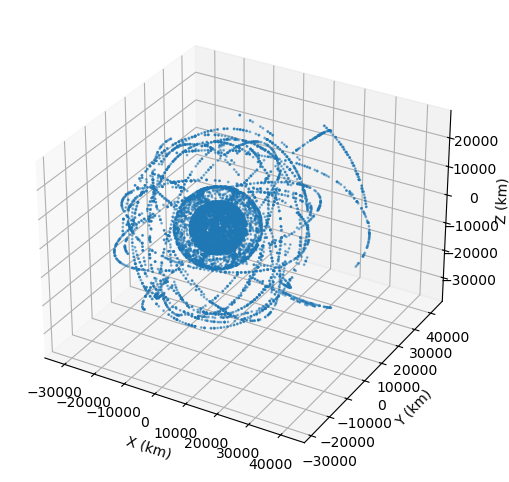

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sample = merged.sample(10000)  # ploted a sample to keep it fast

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(sample["x"], sample["y"], sample["z"], s=1, alpha=0.5)
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
plt.show()


A 3D scatter plot of orbital positions was generated from a sample of 10,000 points. The plot shows circular/elliptical trajectories around Earth, with dense orbital shells corresponding to Low Earth Orbit and other regimes. This validates that the consolidated dataset is correct and aligned with physical expectations.